In [2]:
from config import setup, import_and_display_fnc
setup()

# A strike slip fault underneath topography.

## Mathematical background
Note that much of the discussion here parallels the discussion in [the section on solving topographic problems with TDEs](../tdes/sa_tdes).

Last time we solved for the displacement and stress given slip on an infinitely long strike slip fault. This time, we'll make the problem more interesting (and a bit harder!) by adding in a free surface. First, we'll replicate classical solutions for the surface displacement on a half-space given slip on a fault. Then, we'll add in a topographic free surface and have some fun!

Note that mathematicians may be uncomfortable with the precision of some of the statements here. If you feel that way, I'd recommend taking a look at an [integral equations textbook like Kress](https://www.springer.com/us/book/9781461495925).

Let's start with the integral equation for displacement resulting from slip on a crack/fault and displacement and traction on another arbitrary surface:

\begin{equation}
u(\mathbf{p}) = \int_{H} G(\mathbf{p}, \mathbf{q}) t(\mathbf{q}) d\mathbf{q} - \int_{H} \frac{\partial G}{\partial n_q}(\mathbf{p}, \mathbf{q}) u(\mathbf{q}) d\mathbf{q} -\int_{F} \frac{\partial G}{\partial n_q}(\mathbf{p}, \mathbf{q}) s(\mathbf{q}) d\mathbf{q}
\end{equation}

where $H$ is the surface, $F$ is the fault, $t$ is traction, $u$ is displacement and $s$ is slip. Immediately, we can see that, for a free surface, the first term is zero because the traction is zero, so we are left with:

\begin{equation}
u(\mathbf{p}) = -\int_{H} \frac{\partial G}{\partial n_q}(\mathbf{p}, \mathbf{q}) u(\mathbf{q}) d\mathbf{q} -\int_{F} \frac{\partial G}{\partial n_q}(\mathbf{p}, \mathbf{q}) s(\mathbf{q}) d\mathbf{q}
\end{equation}

So, this equation says that we can calculate displacement anywhere if we know displacement on $H$ and slip on $F$. But, we don't know the displacement on $H$! So, step one is going to be solving for the unknown displacement on the surface $H$.

To solve for surface displacement, intuitively, we need to reduce from two unknowns to one unknown in this equation. Currently we have both the unknown displacement on $H$ and the unknown displacement at an arbitrary point in the volume, $u(\mathbf{p})$. To remedy this situation, we will simply choose to only enforce the integral equation at boundary points $\mathbf{p} \in H$. This can be proven sufficient for the equation to hold everywhere and is the fundamental basis of boundary value problems in potential theory and elastostatics. Because $u$ is now only evaluated on the boundary, this equation is solvable for $u(\mathbf{p})$ given $s$.

```{note}
**Uniqueness**: In informal terms, the uniqueness theorems state that for a linear elastic boundary value problem, if we know displacement and traction on the boundary of the domain, then we can calculate displacement and traction everywhere in the volume.
```

Re-arranging to put the unknown displacement on the left hand side:
\begin{equation}
u(\mathbf{p}) + \int_{H} \frac{\partial G}{\partial n_q}(\mathbf{p}, \mathbf{q}) u(\mathbf{q}) d\mathbf{q} = -\int_{F} \frac{\partial G}{\partial n_q}(\mathbf{p}, \mathbf{q}) s(\mathbf{q}) d\mathbf{q}  ~~~~~~ \forall \mathbf{p} \in H
\end{equation}

Note that the integrals are now being evaluated in their singular limits. Previously, we have only evaluated nearly singular integrals that arise when the observation point is very close to the source surface. Fortunately, QBX works just as well in the limit to the boundary and as a result, nothing about our integration procedures will need to change.

Once discretized using our QBX-based quadrature tools from the previous sections, this will look like:
\begin{equation}
\mathbf{Iu} + \mathbf{Au} = \mathbf{Bs}
\end{equation}

where $\mathbf{A}$ and $\mathbf{B}$ are matrices representing the action of the integral terms on surface displacement and fault slip respectively. $\mathbf{I}$ is the identity matrix.

## Solving for surface displacement

For the first section, we're going to reproduce analytical solutions for the displacement due to slip on a buried fault under a half space. That solution {cite:p}`segallEarthquakeVolcanoDeformation2010` is:

\begin{equation}
u_z = \frac{-s}{2\pi}\bigg[\tan^{-1}(\frac{x}{y + d_1}) - \tan^{-1}(\frac{x}{y - d_1}) - \tan^{-1}(\frac{x}{y + d_2}) + \tan^{-1}(\frac{x}{y - d_2}) \bigg]
\end{equation}

To start with the numerical implementation, we'll define two surfaces. The `fault_fnc` function will define a fault extending from 0.5 units depth to 1.5 units depth and the `flat_fnc` function will define a free surface extending from -25 to 25 units along the x axis.

Note that while we're trying to approximate a free surface, we won't attempt to actually have an infinite surface here. It will turn out that 25 units in both directions is enough to get a very good match with the analytical solution. If we truly wanted to model an infinite surface numerically, I could imagine achieving that via an adaptive quadrature method combined with something like [Gauss-Laguerre quadrature](https://en.wikipedia.org/wiki/Gauss%E2%80%93Laguerre_quadrature). I would enjoy trying that out some day! However, the goal here isn't to actually model an infinite domain. The Earth is not infinite! Instead, the goal is simply to demonstrate that our numerical methods work on an analytically tractable problem before moving on to problems that are not analytically intractable.

In [344]:
import numpy as np
import matplotlib.pyplot as plt
from common import (
    discretize_symbolic_surface,
    gauss_rule,
    double_layer_matrix,
    qbx_setup,
    interior_matrix,
    build_interpolator,
    interp_surface,
    line,
    pts_grid
)

fault_depth = 0.5
def fault_fnc(n):
    return line(n, (0, -0.5), (0, -2.5))


surf_L = 25
def flat_fnc(n):
    return line(n, (surf_L, 0), (-surf_L, 0))

Conceptually, the $\mathbf{A}$ matrix is the interaction of the flat free surface with itself. Let's build that matrix first using the QBX tools from the last two sections. As mentioned, we won't need to do anything fundamentally different for evaluating these integrals in the limit of the observation point being on the boundary. In fact, because the observation surface and the source surface are the same, we can avoid a lot of the complexity in the `qbx_interior_eval_matrix` and `interior_matrix` functions. We'll create a new `self_interaction_matrix` function:

In [171]:
import_and_display_fnc('common', 'self_interaction_matrix')
import_and_display_fnc('common', 'interp_matrix')

def self_interaction_matrix(kernel, obs_surface, src_surface, expansions):
    expand_mat = qbx_expand_matrix(kernel, src_surface, expansions)
    eval_mat = qbx_eval_matrix(obs_surface.pts[None,:], expansions)[0]
    I = np.real(np.sum(eval_mat[:, None, :, None] * expand_mat, axis=2))
    return I, expand_mat, eval_mat

def interp_matrix(interpolator, out_xhat):
    # This code is based on the code in
    # scipy.interpolate.BarycentricInterpolator._evaluate but modified to
    # construct a matrix.
    dist = (interpolator.Cinv * out_xhat[:,None]) - I.xi

    # Remove zeros so we don't divide by zero.
    z = (c == 0)
    c[z] = 1

    # The barycentric interpolation formula
    c = I.wi / c
    interp_matrix = c / np.sum(c, axis=-1)[:,None]

    # Handle points where out_xhat is in an entry in interpolator.xi
    r = np.nonzero(z)
    interp_intercept = np.zeros(interp_matrix.shape[0])
    interp_matrix[r[:-1]] = 0
    interp_intercept[r[:-1]] = I.yi[r[-1],0]

    return interp_matrix, interp_intercept

In [355]:
flat = flat_fnc(1000)
flat_interp = interp_surface(flat, *gauss_rule(2 * flat.n_pts))

flat_expansions = qbx_setup(flat, mult=5.0, direction=1, p=6)
A_raw = self_interaction_matrix(double_layer_matrix, flat, flat_interp, flat_expansions)[0][:,0,:]
Im = interp_matrix(build_interpolator(flat.quad_pts), flat_interp.quad_pts)
A = A_raw.dot(Im)

For the $\mathbf{B}$ term, we don't need to bother with QBX and can just directly perform the boundary integrals. This is because the observation points are sufficiently far away from the source fault surface that there are no nearly-singular or singular integrals. Note that we apply unit slip along the entire fault. In many models, this would be problematic because the fault tip displacement discontinuities introduce stress singularities into the model. However, for the sake of comparing with the analytical solution, we can accept the stress singularities for now. And because we are not evaluating stress near the fault, we don't need to worry about the issue.

For the same reason, we don't need many quadrature points for the fault. We can achieve machine precision with just 25 quadrature points.

In [356]:
fault = fault_fnc(25)
B = -double_layer_matrix(fault, flat.pts)[:, 0, :]

And remembering the identity matrix term, we form the full left hand side as $\mathbf{I} + \mathbf{A}$.

In [357]:
lhs = np.eye(A.shape[0]) + A

Then, apply unit slip along the entire fault to compute the right hand side.

In [358]:
slip = np.ones(fault.n_pts)
rhs = B.dot(slip)

And finally solve the linear system for the unknown displacements!

In [359]:
surf_disp = np.linalg.solve(lhs, rhs)

And let's compare with the analytical solution in the figures below. The match is quite good. Looking at the error figure, a couple things stand out:
1. The tips of the free surface has comparatively high errors. This is simply due to the difference between a finite free surface and the infinite free surface in the analytical solution.
2. The error is extremely low everywhere else. We are seeing 6 to 13 digits of accuracy!
3. The error is also higher near the fault, but we're still seeing almost 5 digits of accuracy. The discretization error is likely to be highest where the gradients in the solution are largest. The gradients are largest near the fault. This could be remedied by having a denser boundary grid near the fault.

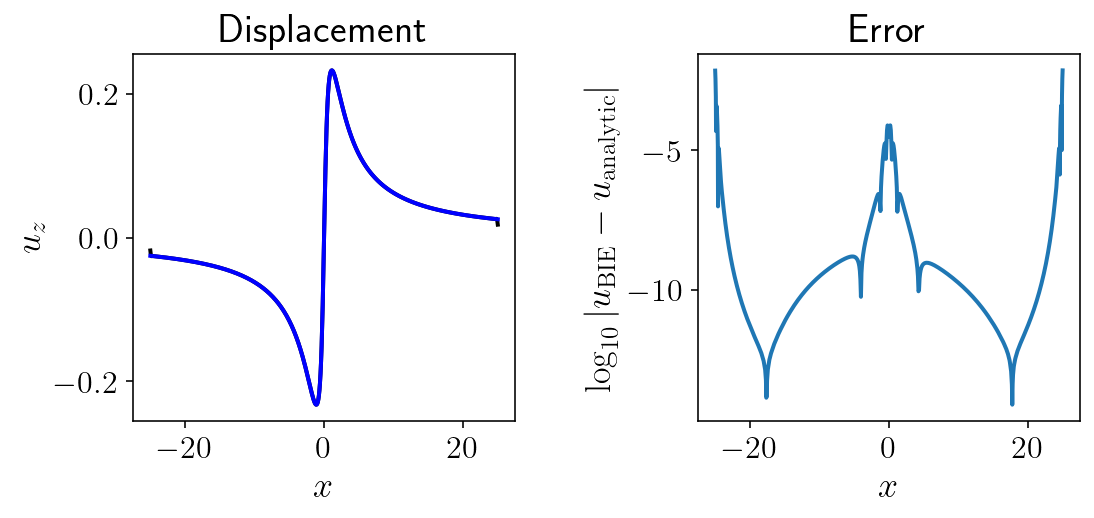

In [374]:
s = 1.0
analytical = (
    -s
    / (2 * np.pi)
    * (
        np.arctan(flat.pts[:,0] / (flat.pts[:,1] + 2.5))
        - np.arctan(flat.pts[:,0] / (flat.pts[:,1] - 2.5))
        - np.arctan(flat.pts[:,0] / (flat.pts[:,1] + 0.5))
        + np.arctan(flat.pts[:,0] / (flat.pts[:,1] - 0.5))
    )
)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(flat.pts[:,0], surf_disp, 'k-')
plt.plot(flat.pts[:,0], analytical, 'b-')
plt.xlabel("$x$")
plt.ylabel("$u_z$")
plt.title("Displacement")

plt.subplot(1, 2, 2)
plt.plot(flat.pts[:,0], np.log10(np.abs(surf_disp - analytical)))
plt.xlabel("$x$")
plt.ylabel(r"$\log_{10}|u_{\textrm{BIE}} - u_{\textrm{analytic}}|$")
plt.title("Error")
plt.tight_layout()
plt.show()

## Evaluating interior displacement

In [318]:
nobs = 100
zoomx = [-2.5, 2.5]
zoomy = [-4.5, 0.5]
xs = np.linspace(*zoomx, nobs)
ys = np.linspace(*zoomy, nobs)
obs_pts = pts_grid(xs, ys)

Now that we have the surface displacement, we can return to the integral form of the interior displacement:

\begin{equation}
u(\mathbf{p}) = \int_{H} \frac{\partial G}{\partial n_q}(\mathbf{p}, \mathbf{q}) u(\mathbf{q}) d\mathbf{q} +\int_{F} \frac{\partial G}{\partial n_q}(\mathbf{p}, \mathbf{q}) s(\mathbf{q}) d\mathbf{q}
\end{equation}

and, using QBX via the `interior_eval` function from the last section, directly calculate the two integrals on the right hand side. The integral over $H$ will be `disp_flat` and the integral over $F$ will be `disp_fault`.

In [341]:
fault_expansions = qbx_setup(fault, mult=5.0)

disp_flat = interior_matrix(
    double_layer_matrix,
    flat_interp,
    obs_pts,
    flat_expansions
).dot(Im).dot(surf_disp).reshape((nobs, nobs))

disp_fault = interior_matrix(
    double_layer_matrix,
    fault,
    obs_pts,
    fault_expansions
).dot(slip).reshape((nobs, nobs))

disp_full = disp_flat + disp_fault

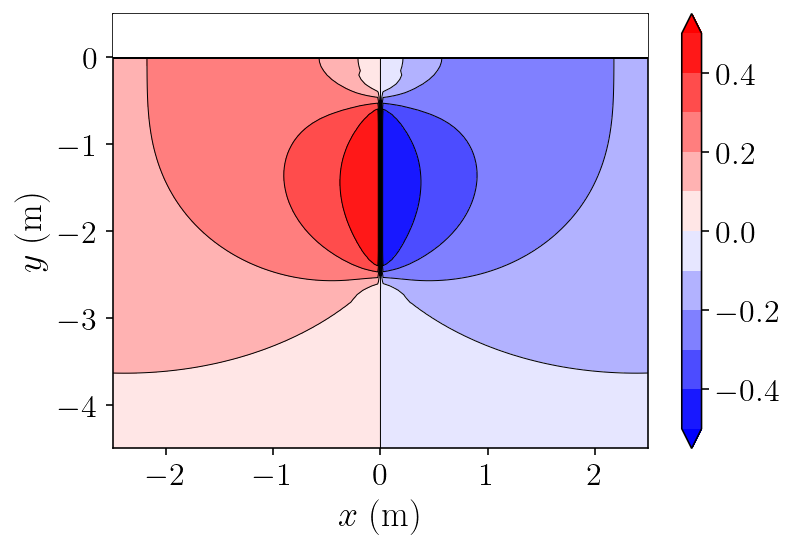

In [342]:
levels = np.linspace(-0.5, 0.5, 11)
cntf = plt.contourf(obsx, obsy, disp_full, levels=levels, extend="both", cmap="bwr")
plt.contour(
    obsx,
    obsy,
    disp_full,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels,
    extend="both",
)
plt.plot(flat.pts[:,0], flat.pts[:,1], "k-", linewidth=1.5)
plt.plot(fault.pts[:,0], fault.pts[:,1], "k-", linewidth=1.5)
plt.fill(np.array([np.min(zoomx), np.max(zoomx), np.max(zoomx), np.min(zoomx)]), np.array([0, 0, np.max(zoomy), np.max(zoomy)]), "w", zorder=100)

plt.colorbar(cntf)
plt.xlim(zoomx)
plt.ylim(zoomy)
plt.xlabel("$x \; \mathrm{(m)}$")
plt.ylabel("$y \; \mathrm{(m)}$")
plt.show()

## Adding topography

In the rest of this section, we'll replicate the calculation above except for a free surface with topography. The calculations will be identical except for the construction of the surface itself.

First, I'll construct a mesh with a Gaussian shaped hill above the fault.

In [9]:


sp.Eq(sp.var("x,y"), sp.Tuple(sym_x, sym_y))

Eq((x, y), (-25*t, -2 + 2*exp(-200*t**2)))

I'll write a generic function here that can accept a parameterization of a curve and return the tuple of symbolic `(x, y, normal_x, normal_y, norm)`.

In [10]:
def symbolic_surface(t, x, y):
    dxdt = sp.diff(x, t)
    dydt = sp.diff(y, t)

    ddt_norm = sp.simplify(sp.sqrt(dxdt ** 2 + dydt ** 2))
    dxdt /= ddt_norm
    dydt /= ddt_norm
    return x, y, -dydt, dxdt, ddt_norm


sym_topo = symbolic_surface(sym_t, sym_x, sym_y)

Here are the symbolic normal vector and norm of the transformation.

I'll plot a quick diagram of the mesh and the surface normals.

In [350]:
import sympy as sp

t = sp.symbols("t")
x = -surf_L * sym_t
y = sp.exp(-(sym_t ** 2) * 200) * sp.Rational(2.0) - sp.Rational(2.0)

qr_topo = gauss_rule(800)
topo = discretize_symbolic_surface(*qr_topo, t, x, y)

(-3.5, 1.5)

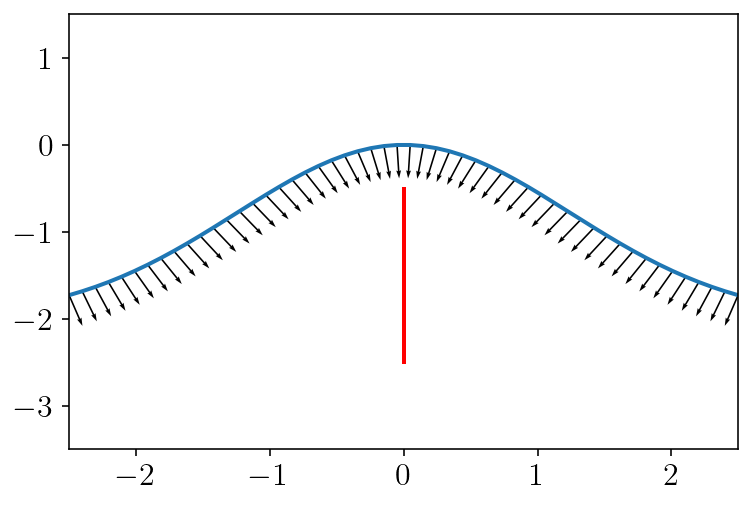

In [351]:
plt.plot(topo.pts[:,0], topo.pts[:,1])
plt.quiver(topo.pts[:,0], topo.pts[:,1], topo.normals[:,0], topo.normals[:,1], scale=20)
plt.plot(fault.pts[:,0], fault.pts[:,1], 'r-')
plt.xlim([-2.5, 2.5])
plt.ylim([-3.5, 1.5])

And let's follow the same procedure as before, we'll solve for the surface displacement. The shape doesn't look that different from before, but the peak surface displacements near the fault are a bit higher.

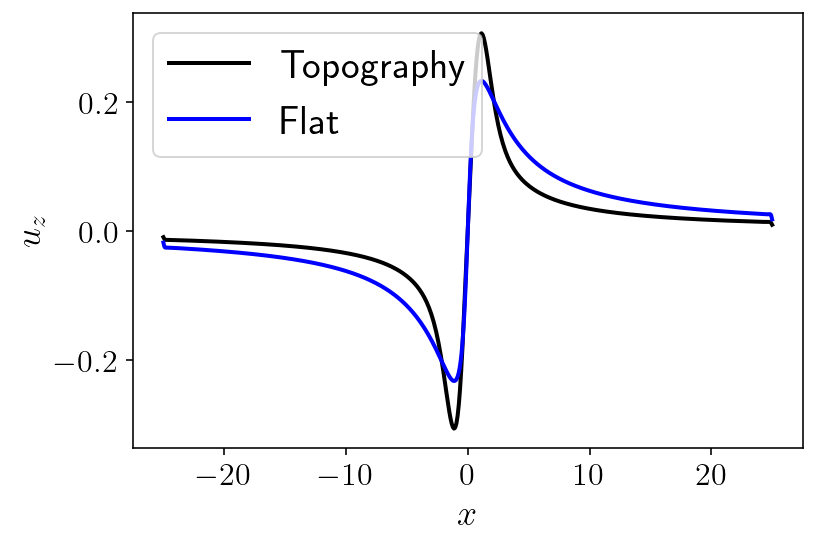

In [362]:
topo_interp = interp_surface(topo, *gauss_rule(2 * topo.n_pts))
topo_expansions = qbx_setup(topo, mult=5.0, direction=1, p=6)

A_raw = self_interaction_matrix(double_layer_matrix, topo, topo_interp, topo_expansions)[0][:,0,:]
Im = interp_matrix(build_interpolator(topo.quad_pts), topo_interp.quad_pts)
A = A_raw.dot(Im)

B = -double_layer_matrix(fault, topo.pts)[:, 0, :]
rhs = B.dot(slip)
lhs = np.eye(A.shape[0]) + A
surf_disp_topo = np.linalg.solve(lhs, rhs)

plt.plot(topo.pts[:,0], surf_disp_topo, "k-", label="Topography")
plt.plot(flat.pts[:,0], surf_disp, "b-", label="Flat")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$u_z$")
plt.show()

## Interior displacement under topography

In [365]:
nobs = 200
zoomx = [-2.5, 2.5]
zoomy = [-3.5, 1.5]
xs = np.linspace(*zoomx, nobs)
ys = np.linspace(*zoomy, nobs)
obs_pts = pts_grid(xs, ys)

And finally, we'll plot the displacement in the volume underneath the topography. Just like the in the flat case. To show the effect of both integral terms, I've separated out the topography integral term and the fault integral term in the plots.

In [368]:
disp_topo = interior_matrix(
    double_layer_matrix,
    topo_interp,
    obs_pts,
    topo_expansions
).dot(Im).dot(surf_disp_topo).reshape((nobs, nobs))

disp_fault = interior_matrix(
    double_layer_matrix,
    fault,
    obs_pts,
    fault_expansions
).dot(slip).reshape((nobs, nobs))

disp_full = disp_topo + disp_fault

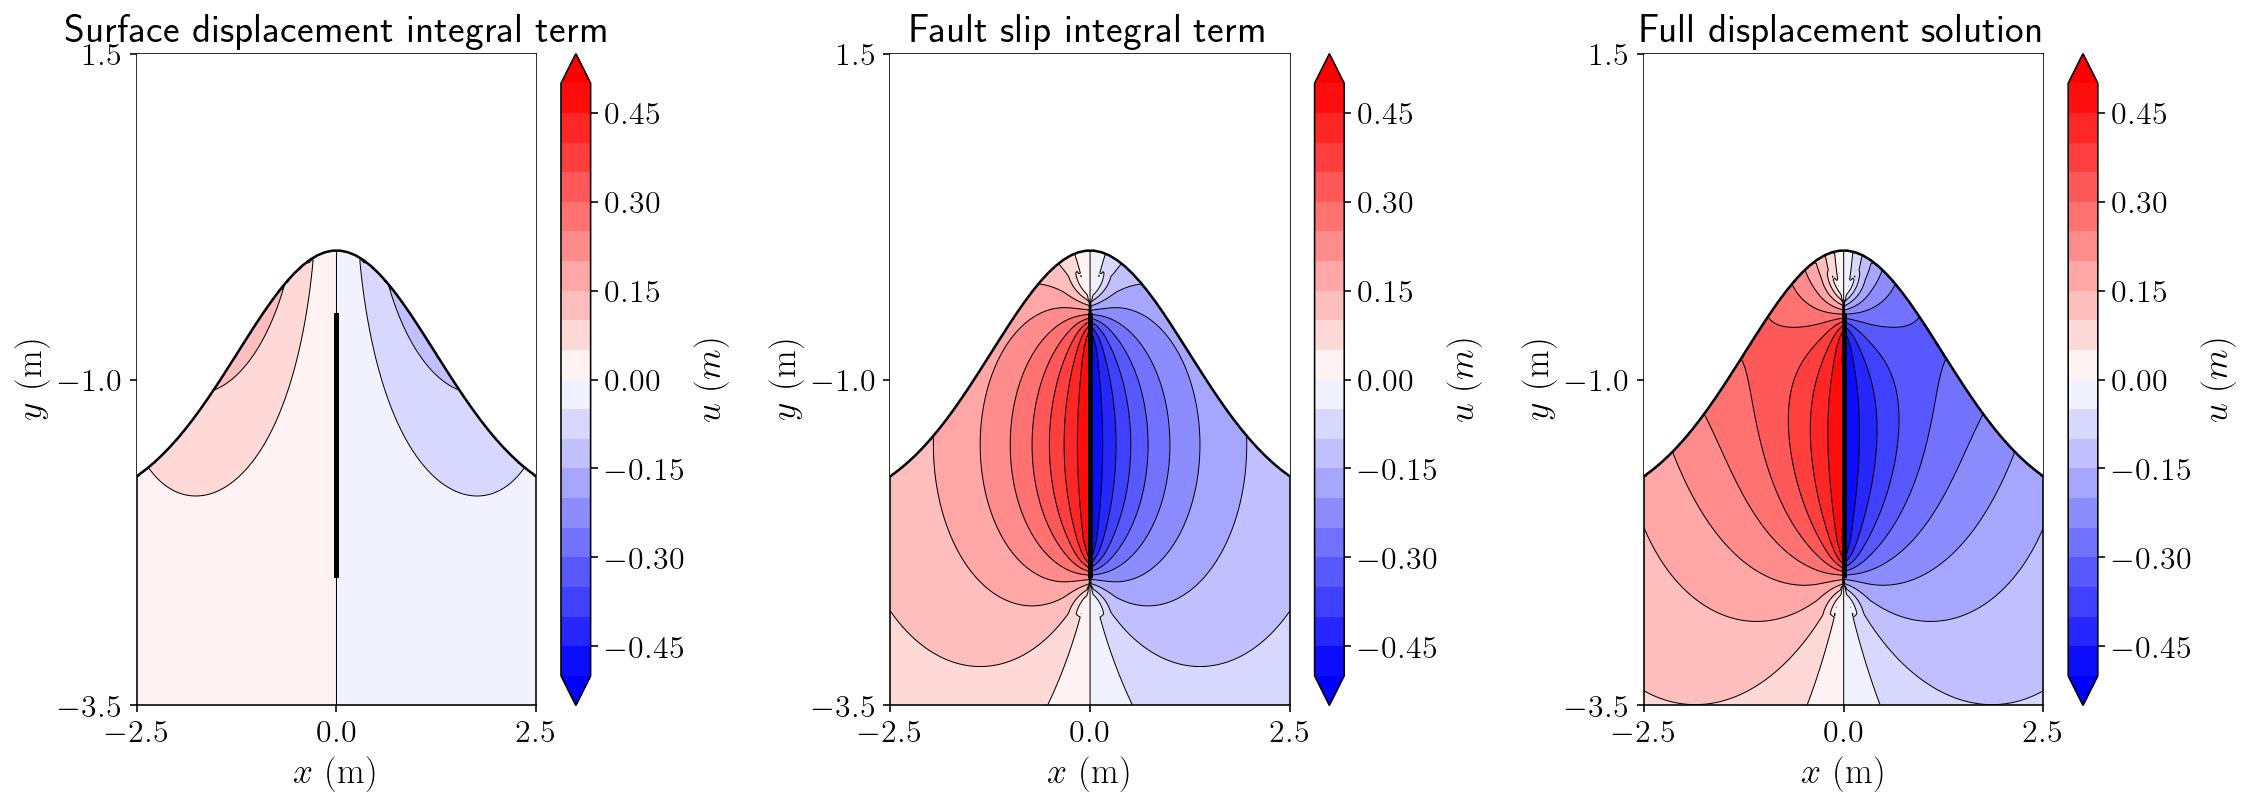

In [373]:
obsx = obs_pts[:,0].reshape((nobs, nobs))
obsy = obs_pts[:,1].reshape((nobs, nobs))

levels = np.linspace(-0.5, 0.5, 21)
plt.figure(figsize=(16, 6))
plt.subplot(1, 3, 1)
cntf = plt.contourf(obsx, obsy, disp_topo, levels=levels, extend="both", cmap="bwr")
plt.contour(
    obsx,
    obsy,
    disp_topo,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels,
    extend="both",
)
plt.plot(topo.pts[:,0], topo.pts[:,1], "k-", linewidth=2.5)
plt.plot(fault.pts[:,0], fault.pts[:,1], "k-", linewidth=2.5)
fill_poly = np.append(topo.pts[:,0], np.array([np.min(topo.pts[:,0]), np.max(topo.pts[:,0])])), np.append(topo.pts[:,1], np.array([zoomy[1], zoomy[1]]))
plt.fill(*fill_poly, "w", zorder=100)
plt.colorbar(cntf, label="$u \; (m)$")
plt.xlim(zoomx)
plt.ylim(zoomy)
plt.xticks(np.array([zoomx[0], 0, zoomx[1]]))
plt.yticks(np.array([zoomy[0], -1, zoomy[1]]))
plt.xlabel("$x ~ \mathrm{(m)}$")
plt.ylabel("$y ~ \mathrm{(m)}$")
plt.title("Surface displacement integral term")

plt.subplot(1, 3, 2)
cntf = plt.contourf(obsx, obsy, disp_fault, levels=levels, extend="both", cmap="bwr")
plt.contour(
    obsx,
    obsy,
    disp_fault,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels,
    extend="both",
)
plt.plot(topo.pts[:,0], topo.pts[:,1], "k-", linewidth=2.5)
plt.plot(fault.pts[:,0], fault.pts[:,1], "k-", linewidth=2.5)
plt.fill(*fill_poly, "w", zorder=100)
plt.colorbar(cntf, label="$u \; (m)$")
plt.xlim(zoomx)
plt.ylim(zoomy)
plt.xticks(np.array([zoomx[0], 0, zoomx[1]]))
plt.yticks(np.array([zoomy[0], -1, zoomy[1]]))
plt.xlabel("$x ~ \mathrm{(m)}$")
plt.ylabel("$y ~ \mathrm{(m)}$")
plt.title("Fault slip integral term")

plt.subplot(1, 3, 3)
cntf = plt.contourf(obsx, obsy, disp_topo + disp_fault, levels=levels, extend="both", cmap="bwr")
plt.contour(
    obsx,
    obsy,
    disp_topo + disp_fault,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels,
    extend="both",
)
plt.plot(topo.pts[:,0], topo.pts[:,1], "k-", linewidth=2.5)
plt.plot(fault.pts[:,0], fault.pts[:,1], "k-", linewidth=2.5)
plt.fill(*fill_poly, "w", zorder=100)
plt.colorbar(cntf, label="$u \; (m)$")
plt.xlim(zoomx)
plt.ylim(zoomy)
plt.xticks(np.array([zoomx[0], 0, zoomx[1]]))
plt.yticks(np.array([zoomy[0], -1, zoomy[1]]))
plt.xlabel("$x ~ \mathrm{(m)}$")
plt.ylabel("$y ~ \mathrm{(m)}$")
plt.title("Full displacement solution")

plt.tight_layout()
plt.show()